### Importing some useful libraries and loading the dataset from an excel file

In [1]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DataConversionWarning)
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

# generate random integer values
from random import seed
from random import randint
seed(1)

directory = os.getcwd()
data = pd.read_excel(directory +'/Needs.xls')

data = pd.read_excel(directory +'/Needs.xls')
data2 = data[ (data['Income'] >= 13) & (data['Wealth'] > 5)]
data.head()

,ID,Age,Gender,FamilyMembers,FinancialEducation,RiskPropensity,Income,Wealth,IncomeInvestment,AccumulationInvestment
0,1,60,0,2,0.228685,0.233355,68.181525,53.260067,0,1
1,2,78,0,2,0.358916,0.170911,21.807595,135.550048,1,0
2,3,33,1,2,0.317515,0.249703,23.252747,66.303678,0,1
3,4,69,1,4,0.767685,0.654597,166.189034,404.997689,1,1
4,5,58,0,3,0.429719,0.349039,21.186723,58.911930,0,0


### Imbalanced Dataset
I found out that our dataset is unbalanced concerning the Need of Income Investment. In this case the two classes of the IncomeInvestment are not represented equally, and it can give us some issues with classification problems. 
In the case of Imbalanced Dataset there are several options: 
1. Collect more data
2. Resample the Dataset (over-sampling == add copies of instances from the under-represented class || under-sampling == randomly delete instances from the over-represented class)
3. Randomly sample the attributes from instances in the minority class, in order to generate new samples
4. Try penalized models == use the same algorithm but give them a different perspective on the problem; penalized classification imposes an additional cost on the model for making classification mistakes on the minority class during training. These penalties can bias the model to pay more attention to the minority class

I decided to follow the second case, under-sampling our dataset. According to this choice, I randomly deleted 300 observations with (IncomeInvestment = 0; AccumulationInvestment = 0) and 300 observations with (IncomeInvestment = 0; AccumulationInvestment = 1). In this way our dataset is now more balanced, as one can see from the second histogram plot

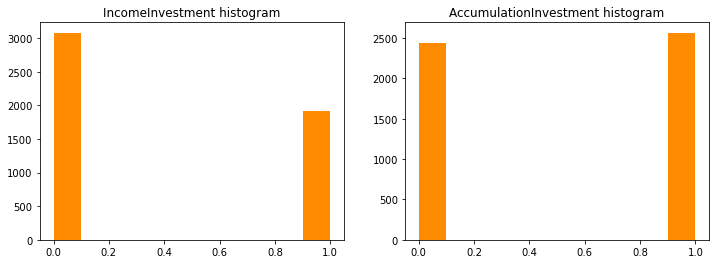

In [2]:
#Inc = data[data['IncomeInvestment'] == 1]
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4))
ax1.hist(data.IncomeInvestment, color='darkorange')
ax1.set_title('IncomeInvestment histogram')

ax2.hist(data.AccumulationInvestment, color='darkorange')
ax2.set_title('AccumulationInvestment histogram')
fig.show()
plt.savefig('imbalanced.jpg', dpi=100, bbox_inches='tight')

In [3]:
No_Inc_Acc = data[(data['IncomeInvestment'] == 0) & (data['AccumulationInvestment'] == 1)]
No_Inc_No_Acc = data[(data['IncomeInvestment'] == 0) &(data['AccumulationInvestment'] == 0)]
print('Inc: ' + str(len(data[data['IncomeInvestment'] == 1])) + ' || No_Inc: ' + str(len(data[data['IncomeInvestment'] == 0])))
print('Inc_Acc: ' + str(len(No_Inc_Acc)) + ' || Inc_No_Acc: ' + str(len(No_Inc_No_Acc)))

Inc: 1918 || No_Inc: 3082
Inc_Acc: 1568 || Inc_No_Acc: 1514


In [4]:
data_bal = data

people_Acc = []
ID_Acc = []
people_No = []
ID_No = []

for i in range(300):
    value_Acc = randint(0,len(No_Inc_Acc)-1)
    value_No = randint(0,len(No_Inc_No_Acc)-1)
    
    while value_Acc in people_Acc:
        value_Acc = randint(0,len(No_Inc_Acc)-1)
    while value_No in people_No:
        value_No = randint(0,len(No_Inc_No_Acc)-1)
    
    people_Acc.insert(-1, value_Acc)
    ID_Acc.insert(-1, No_Inc_Acc.iloc[value_Acc].ID)
    people_No.insert(-1, value_No)
    ID_No.insert(-1, No_Inc_No_Acc.iloc[value_No].ID)
    
    data_bal = data_bal[(data_bal['ID']!=No_Inc_Acc.iloc[value_Acc].ID) & (data_bal['ID']!=No_Inc_No_Acc.iloc[value_No].ID)]

#### Histogram plot for our balanced dataset
I decided not to delete more observations in order to have a fully-balanced set because I didn't want to study a too small dataset 

IncomeInvestment == 0: 2482
IncomeInvestment == 1: 1918


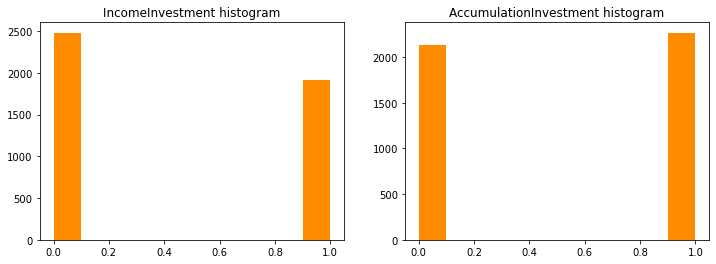

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4))
ax1.hist(data_bal.IncomeInvestment, color='darkorange')
ax1.set_title('IncomeInvestment histogram')

ax2.hist(data_bal.AccumulationInvestment, color='darkorange')
ax2.set_title('AccumulationInvestment histogram')

fig.show()

plt.savefig('balanced.jpg', dpi=100, bbox_inches='tight')

data=data_bal
print("IncomeInvestment == 0: " + str(len(data[data.IncomeInvestment == 0])))
print("IncomeInvestment == 1: " + str(len(data[data.IncomeInvestment == 1])))

# ADABOOST AND GRADIENT BOOST 
AdaBoost, also called Adaptive Boosting, and Gradient Boosting are two techniques in Machine Learning used as Ensemble Methods. These algorithms build a model and firstly give equal weigths to all the data points and then they assigns higher weights to points that are wrongly classified. In this way all the points with higher weights are given more importance in the next model. The algorithms then keep training model untill they reach a certain threshold. These ensemble methods work by combining multiple weak models to get better performance
# Data split
In this study I decided to randomly split the dataset into three parts:
* 70% of the dataset is the training set
* 15% of the dataset is the testing set
* 15% of the dataset is the validation set

I used the training set to train all the algorithms,the testing set in order to choose the best hyperparameters for each model, and then the validation set to compute the accuracy and all the error variables.


## Gradient Boosting AccumulationInvestment
For this algorithms I decided to divide our study into two cases. In the first case I considered only the AccumulationInvestment case, so I dropped the output column of the IncomeInvestment

In [6]:
X = data
#X = X.drop('ID', 1)
X = X.drop('IncomeInvestment', 1)
X = X.drop('AccumulationInvestment', 1)

Y = data
Y = Y.drop('Gender', 1)
Y = Y.drop('ID', 1)
Y = Y.drop('Age', 1)
Y = Y.drop('FamilyMembers', 1)
Y = Y.drop('FinancialEducation', 1)
Y = Y.drop('RiskPropensity', 1)
Y = Y.drop('Income', 1)
Y = Y.drop('Wealth', 1)
Y = Y.drop('IncomeInvestment', 1)

X_train2, X_test2, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_test = X_test2.drop('ID',1)
X_train = X_train2.drop('ID',1)
X_validate, X_test, Y_validate, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=45)

In [7]:
AdaBoost = AdaBoostClassifier()
AdaBoost.fit(X_train, Y_train)
Y_pred = AdaBoost.predict(X_test)
print("Accuracy AdaBoost = " + str(accuracy_score(Y_test, Y_pred)))


GradientBoost_Acc = GradientBoostingClassifier()
GradientBoost_Acc.fit(X_train, Y_train)
Y_pred = GradientBoost_Acc.predict(X_test)
print("Accuracy GradientBoost = " + str(accuracy_score(Y_test, Y_pred)))

Accuracy AdaBoost = 0.7348484848484849
Accuracy GradientBoost = 0.7878787878787878


## Shapley Values Gradient Boosting AccumulationInvestment
I plotted the features importance and I found out that Gender and FamilyMembers are not important for our classification problem

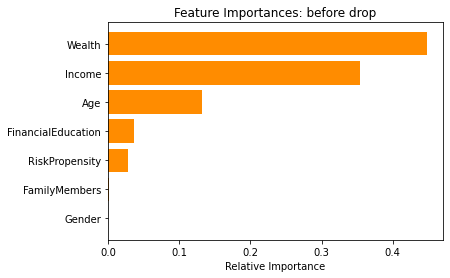

In [8]:
importances = GradientBoost_Acc.feature_importances_
indices = np.argsort(importances)
features = X_train.columns

fig, ax = plt.subplots()

ax.set_title('Feature Importances: before drop')
ax.barh(range(len(indices)), importances[indices], color='darkorange', align='center')
ax.set_yticks(range(len(indices)), [features[i] for i in indices])
ax.set_xlabel('Relative Importance')
fig.show()

In [9]:
X = data
#X = X.drop('ID', 1)
X = X.drop('IncomeInvestment', 1)
X = X.drop('AccumulationInvestment', 1)
X = X.drop('Gender', 1)
X = X.drop('FamilyMembers', 1)

Y = data
Y = Y.drop('Gender', 1)
Y = Y.drop('ID', 1)
Y = Y.drop('Age', 1)
Y = Y.drop('FamilyMembers', 1)
Y = Y.drop('FinancialEducation', 1)
Y = Y.drop('RiskPropensity', 1)
Y = Y.drop('Income', 1)
Y = Y.drop('Wealth', 1)
Y = Y.drop('IncomeInvestment', 1)

X_train2, X_test2, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_test = X_test2.drop('ID',1)
X_train = X_train2.drop('ID',1)
X_validate, X_test, Y_validate, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=45)

In [10]:
estimators = [100, 150, 200, 250]
learn = [0.06, 0.075, 0.1, 0.2, 0.3]
acc = 0
for i in estimators:
    for j in learn:
        model = GradientBoostingClassifier(n_estimators=i, learning_rate=j)
        model.fit(X_train, Y_train)
        accuracy = accuracy_score(Y_test, model.predict(X_test))
        if acc < accuracy:
            acc = accuracy
            best = model
            n_est = i
            learning = j
        
print("Best gradient boosting is with n_estimators = " + str(n_est) + 
      " and learning_rate = " + str(learning))

Best gradient boosting is with n_estimators = 250 and learning_rate = 0.075


### I found out that for studying the AccumulationInvestment the best parameters of Gradient Boosting are n_estimators = 200 and learning_rate = 0.075
I used the validation set to compute the accuracy of our model

In [11]:
GradientBoost_Acc = GradientBoostingClassifier(n_estimators=250, learning_rate=0.075)
GradientBoost_Acc.fit(X_train, Y_train)
Y_pred = GradientBoost_Acc.predict(X_validate)
print("Accuracy GradientBoost = " + str(accuracy_score(Y_validate, Y_pred)))

Accuracy GradientBoost = 0.7621212121212121


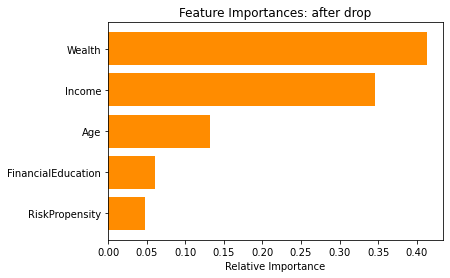

In [12]:
importances = GradientBoost_Acc.feature_importances_
indices = np.argsort(importances)
features = X_train.columns

fig, ax = plt.subplots()

ax.set_title('Feature Importances: after drop')
ax.barh(range(len(indices)), importances[indices], color='darkorange', align='center')
ax.set_yticks(range(len(indices)), [features[i] for i in indices])
ax.set_xlabel('Relative Importance')
fig.show()

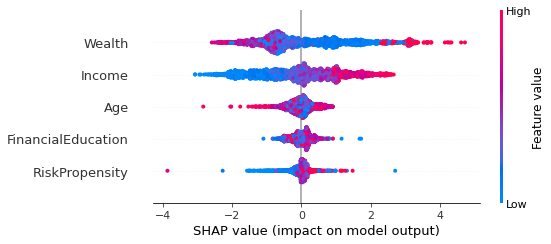

In [13]:
import shap

rf_explainer = shap.TreeExplainer(GradientBoost_Acc)
shap_values = rf_explainer.shap_values(X_train)

fig = shap.summary_plot(shap_values, X_train, show=False)

### Confusion Matrix
Confusion matrix is a specific table layout that allows visualization of the performance of an algorithm. Each row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class.
The goal of a confusion matrix is to give a visual explanation to the goodness of our algorithm, in fact our aim is to maximize the true positive [TP = (true=1; predicted=1)] and true negative [TN = (true=0; predicted=0)] values and minimize the false positive [FP = (true=0; predicted=1)] and false negative [FN = (true=1; predicted=0)] values. 

<Figure size 432x288 with 0 Axes>

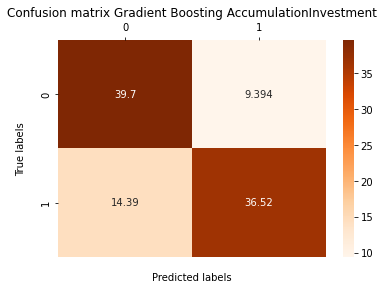

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

Y_pred = GradientBoost_Acc.predict(X_validate)

cm = (confusion_matrix(Y_validate, Y_pred)/len(X_validate))*100
plt.figure(figsize=(6, 4))
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, ax=ax, fmt='.4g', cmap="Oranges")
ax.set_xlabel('\nPredicted labels'); ax.set_ylabel('True labels\n')
ax.xaxis.tick_top()
ax.yaxis.set_ticklabels(['0','1'],verticalalignment='center')
ax.xaxis.set_ticklabels(['0','1'])
ax.set_title('Confusion matrix Gradient Boosting AccumulationInvestment')
fig.show()

In [15]:
print(classification_report(Y_validate, Y_pred))

              precision    recall  f1-score   support

           0       0.73      0.81      0.77       324
           1       0.80      0.72      0.75       336

    accuracy                           0.76       660
   macro avg       0.76      0.76      0.76       660
weighted avg       0.77      0.76      0.76       660



## ROC and Precision-Recall curves

A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system. The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR). The performance of a classifier can be measured using the area under the curve AUC. The greater the area is, the better is the classifier that we obtain. For a classifier, to be useful, the AUC must be AUC > 0.5

A precision-recall curve shows the relationship between precision and sensitivity

AUC AccumulationInvestment case: 0.8326811434450323


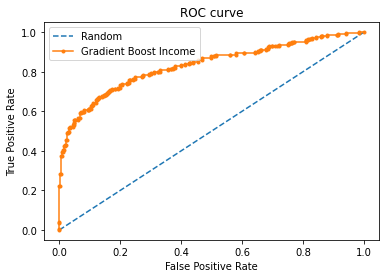

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score

prob = GradientBoost_Acc.predict_proba(X_validate)
prob = prob[:,1]

Acc_auc = roc_auc_score(Y_validate, prob)
print('AUC AccumulationInvestment case: ' + str(Acc_auc))

Acc_fpr, Acc_tpr, _ = roc_curve(Y_validate, prob)

fig, ax = plt.subplots()
ax.plot([0,1], [0,1], linestyle='--', label='Random')
ax.plot(Acc_fpr, Acc_tpr, marker='.', label='Gradient Boost Income')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()
ax.set_title('ROC curve')
fig.show()

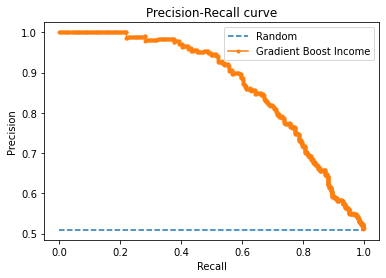

In [17]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

Y_pred = GradientBoost_Acc.predict(X_validate)
Inc_precision, Inc_recall, _ = precision_recall_curve(Y_validate, prob)
Inc_f1, Inc_auc = f1_score(Y_validate, Y_pred), auc(Inc_recall, Inc_precision)

no_skill = len(Y_validate[Y_validate.AccumulationInvestment==1])/len(Y_validate)

fig, ax = plt.subplots()
ax.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Random')
ax.plot(Inc_recall, Inc_precision, marker='.', label='Gradient Boost Income')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()
ax.set_title('Precision-Recall curve')
fig.show()

# Target feature == IncomeInvestment
Now I studied the IncomeInvestment case, by repeating all the previous points 


In [18]:
X = data
#X = X.drop('ID', 1)
X = X.drop('IncomeInvestment', 1)
X = X.drop('AccumulationInvestment', 1)

Y = data
Y = Y.drop('Gender', 1)
Y = Y.drop('ID', 1)
Y = Y.drop('Age', 1)
Y = Y.drop('FamilyMembers', 1)
Y = Y.drop('FinancialEducation', 1)
Y = Y.drop('RiskPropensity', 1)
Y = Y.drop('Income', 1)

Y = Y.drop('Wealth', 1)
Y = Y.drop('AccumulationInvestment', 1)

X_train2, X_test2, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

X_test = X_test2.drop('ID',1)
X_train = X_train2.drop('ID',1)

X_validate, X_test, Y_validate, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=45)

In [19]:
AdaBoost = AdaBoostClassifier()
AdaBoost.fit(X_train, Y_train)
Y_pred = AdaBoost.predict(X_test)
print("Accuracy AdaBoost = " + str(accuracy_score(Y_test, Y_pred)))



GradientBoost_Inc = GradientBoostingClassifier()
GradientBoost_Inc.fit(X_train, Y_train)
Y_pred = GradientBoost_Inc.predict(X_test)
print("Accuracy GradientBoost = " + str(accuracy_score(Y_test, Y_pred)))

Accuracy AdaBoost = 0.7363636363636363
Accuracy GradientBoost = 0.75


## Shapley Values Gradient Boosting IncomeInvestment


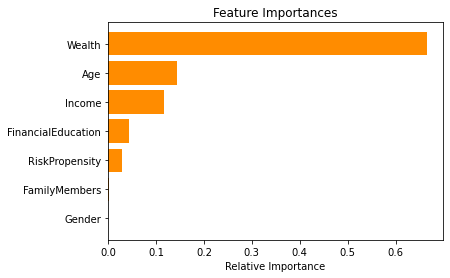

In [20]:
importances = GradientBoost_Inc.feature_importances_
indices = np.argsort(importances)
features = X_train.columns

fig, ax = plt.subplots()

ax.set_title('Feature Importances')
ax.barh(range(len(indices)), importances[indices], color='darkorange', align='center')
ax.set_yticks(range(len(indices)), [features[i] for i in indices])
ax.set_xlabel('Relative Importance')
fig.show()

In [21]:
X = data
#X = X.drop('ID', 1)
X = X.drop('IncomeInvestment', 1)
X = X.drop('AccumulationInvestment', 1)
X = X.drop('Gender', 1)
X = X.drop('FamilyMembers', 1)
#X = X.drop('RiskPropensity', 1)

Y = data
Y = Y.drop('Gender', 1)
Y = Y.drop('ID', 1)
Y = Y.drop('Age', 1)
Y = Y.drop('FamilyMembers', 1)
Y = Y.drop('FinancialEducation', 1)
Y = Y.drop('RiskPropensity', 1)
Y = Y.drop('Income', 1)
Y = Y.drop('Wealth', 1)
Y = Y.drop('AccumulationInvestment', 1)

X_train2, X_test2, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_test = X_test2.drop('ID',1)
X_train = X_train2.drop('ID',1)
X_validate, X_test, Y_validate, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=45)

In [22]:
estimators = [1, 5, 10, 15, 20, 25, 50, 100]
learn = [0.04, 0.05, 0.06, 0.07, 0.08, 0.09]
acc = 0
for i in estimators:
    for j in learn:
        model = GradientBoostingClassifier(n_estimators=i, learning_rate=j)
        model.fit(X_train, Y_train)
        accuracy = accuracy_score(Y_test, model.predict(X_test))
        if acc < accuracy:
            acc = accuracy
            best = model
            n_est = i
            learning = j
        
print("Best gradient boosting is with n_estimators = " + str(n_est) + 
      " and learning_rate = " + str(learning))

Best gradient boosting is with n_estimators = 15 and learning_rate = 0.06


### I found out that the best parameters for Gradient Boosting in the IncomeInvestment case are n_estimators = 15 and learning_rate = 0.06
I used the validation set to compute the Gradient Boosting accuracy

In [23]:
GradientBoost_Inc = GradientBoostingClassifier(n_estimators=15, learning_rate=0.06)
GradientBoost_Inc.fit(X_train, Y_train)
Y_pred = GradientBoost_Inc.predict(X_validate)
print("Accuracy GradientBoost = " + str(accuracy_score(Y_validate, Y_pred)))

Accuracy GradientBoost = 0.8090909090909091


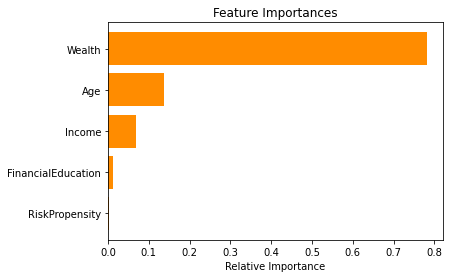

In [24]:
importances = GradientBoost_Inc.feature_importances_
indices = np.argsort(importances)
features = X_train.columns

fig, ax = plt.subplots()

ax.set_title('Feature Importances')
ax.barh(range(len(indices)), importances[indices], color='darkorange', align='center')
ax.set_yticks(range(len(indices)), [features[i] for i in indices])
ax.set_xlabel('Relative Importance')
fig.show()

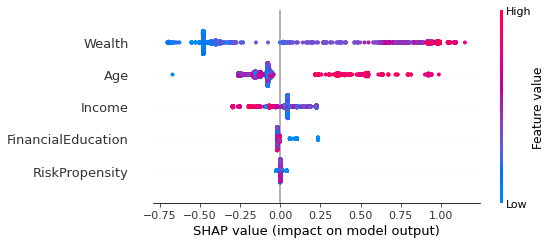

In [25]:
import shap
rf_explainer = shap.TreeExplainer(GradientBoost_Inc)
shap_values = rf_explainer.shap_values(X_train)

fig = shap.summary_plot(shap_values, X_train, show=False)

### Confusion Matrix


<Figure size 432x288 with 0 Axes>

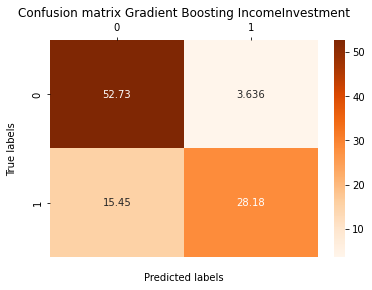

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

cm = (confusion_matrix(Y_validate, Y_pred)/len(X_validate))*100
plt.figure(figsize=(6, 4))
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, ax=ax, fmt='.4g', cmap="Oranges")
ax.set_xlabel('\nPredicted labels'); ax.set_ylabel('True labels\n')
ax.xaxis.tick_top()
ax.yaxis.set_ticklabels(['0','1'],verticalalignment='center')
ax.xaxis.set_ticklabels(['0','1'])
ax.set_title('Confusion matrix Gradient Boosting IncomeInvestment')
fig.show()

In [27]:
print(classification_report(Y_validate, Y_pred))

              precision    recall  f1-score   support

           0       0.77      0.94      0.85       372
           1       0.89      0.65      0.75       288

    accuracy                           0.81       660
   macro avg       0.83      0.79      0.80       660
weighted avg       0.82      0.81      0.80       660



## ROC and Precision-Recall curves


AUC IncomeInvestment case: 0.7930154196535245


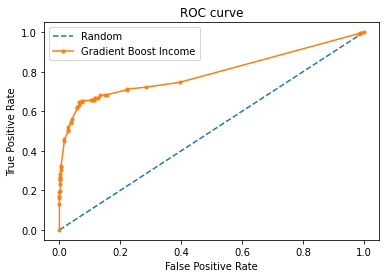

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score

prob = GradientBoost_Inc.predict_proba(X_validate)
prob = prob[:,1]
Inc_auc = roc_auc_score(Y_validate, prob)
print('AUC IncomeInvestment case: ' + str(Inc_auc))

Inc_fpr, Inc_tpr, _ = roc_curve(Y_validate, prob)

fig, ax = plt.subplots()
ax.plot([0,1], [0,1], linestyle='--', label='Random')
ax.plot(Inc_fpr, Inc_tpr, marker='.', label='Gradient Boost Income')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()
ax.set_title('ROC curve')
fig.show()

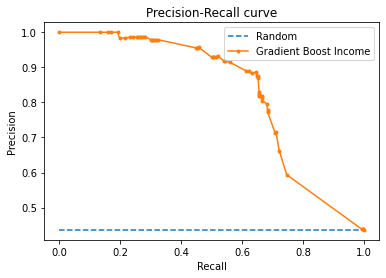

In [29]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

Y_pred = GradientBoost_Inc.predict(X_validate)
Inc_precision, Inc_recall, _ = precision_recall_curve(Y_validate, prob)
Inc_f1, Inc_auc = f1_score(Y_validate, Y_pred), auc(Inc_recall, Inc_precision)

no_skill = len(Y_validate[Y_validate.IncomeInvestment==1])/len(Y_validate)

fig, ax = plt.subplots()
ax.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Random')
ax.plot(Inc_recall, Inc_precision, marker='.', label='Gradient Boost Income')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()
ax.set_title('Precision-Recall curve')
fig.show()

## Now I considered the two classifiers together, and I used them for a first approach to the search of the adeguate product.
I chose randomly from our dataset 5 people, and thanks to the knowledge I have from the two classifier I was able to identify the best product for each person. As one can see, from the 5 people randomly chosen, there is a person for which our algorithm doesn't find any product adeguate for him/her. 
* product type = 0 ==> Income product
* product type = 1 ==> Accumulation product

In [30]:
products = pd.read_excel(directory +'/Needs.xls', sheet_name='Products')
print(products)

    IDProduct  Type  Risk
0           1     1  0.55
1           2     0  0.30
2           3     0  0.12
3           4     0  0.44
4           5     1  0.41
5           6     1  0.36
6           7     1  0.75
7           8     1  0.48
8           9     1  0.27
9          10     0  0.13
10         11     1  0.88


In [31]:
# generate random integer values
from random import seed
from random import randint
seed(3)

X = X.drop('ID',1)

people = []
y1 = []
y2 = []
product_ID = []

for i in range(5):
    value = randint(0,len(data)-1)
    while value in people:
        value = randint(0,len(data)-1)
        
    people.insert(-1, value)
    person = [X.iloc[value]]
    y_Inc = GradientBoost_Inc.predict(person)
    y1.insert(-1, y_Inc[0])
    y_Acc = GradientBoost_Acc.predict(person)
    y2.insert(-1, y_Acc[0])
    
    ID = -1
    product_risk = 0
    Person_risk = X.iloc[value].RiskPropensity

    if y_Inc[0] == y_Acc[0]:  # situazione in cui per entrambi i classifier la persona è nella classe 0 o 1
                        
        for x in range(11):
            if Person_risk > products.iloc[x].Risk and product_risk < products.iloc[x].Risk:
                product_risk = products.iloc[x].Risk
                ID = products.iloc[x].IDProduct
        
    elif y_Inc[0] == 1:
        for x in range(11):
            if Person_risk > products.iloc[x].Risk and product_risk < products.iloc[x].Risk and products.iloc[x].Type == 0:
                product_risk = products.iloc[x].Risk
                ID = products.iloc[x].IDProduct
    
    else:
        for x in range(11):
            if Person_risk > products.iloc[x].Risk and product_risk < products.iloc[x].Risk and products.iloc[x].Type == 1:
                product_risk = products.iloc[x].Risk
                ID = products.iloc[x].IDProduct
    
    product_ID.insert(-1, ID)  
    
    if ID == -1:
        print("For the person number " + str(value) + " there is no product")
    else:
        print("For the person number " + str(value) + " the best product is: \n" + str(products.iloc[int(ID-1)]))
    
    print("-------------------------------------------------\n")

For the person number 1949 the best product is: 
IDProduct    10.00
Type          0.00
Risk          0.13
Name: 9, dtype: float64
-------------------------------------------------

For the person number 1068 the best product is: 
IDProduct    4.00
Type         0.00
Risk         0.44
Name: 3, dtype: float64
-------------------------------------------------

For the person number 3030 the best product is: 
IDProduct    10.00
Type          0.00
Risk          0.13
Name: 9, dtype: float64
-------------------------------------------------

For the person number 3883 there is no product
-------------------------------------------------

For the person number 536 the best product is: 
IDProduct    4.00
Type         0.00
Risk         0.44
Name: 3, dtype: float64
-------------------------------------------------



I noticed that for the person number 3883 we cannot find an adeguate product, in fact the person is of the IncomeInvestment class, but all the IncomeInvestment products have larger risk than the RiskPropensity of the person. One solution could be that for this kind of people, the system assign automatically the product with the highest risk that is lower than the RiskPropensity of the person, even if the product is of the opposite type than the class of the person

In [32]:
print("People = " + str(people))
print("Income class = " + str(y1))
print("Accumulation class = " + str(y2))
print("Products ID = " + str(product_ID))

People = [1068, 3030, 3883, 536, 1949]
Income class = [1, 1, 0, 1, 1]
Accumulation class = [0, 0, 1, 0, 0]
Products ID = [4.0, 10.0, -1, 4.0, 10.0]


In [33]:
print(data.iloc[people[2]])

ID                        4423.000000
Age                         62.000000
Gender                       1.000000
FamilyMembers                2.000000
FinancialEducation           0.238142
RiskPropensity               0.140726
Income                      37.932063
Wealth                      32.638304
IncomeInvestment             0.000000
AccumulationInvestment       1.000000
Name: 4422, dtype: float64


## I define a function that find the best product for a single client


In [34]:
def find_product(classifier_Inc, classifier_Acc, person, products):
    y_Inc = classifier_Inc.predict([person])
    y_Acc = classifier_Acc.predict([person])
    
    ID = -1
    product_risk = 0
    Person_risk = person.RiskPropensity
    
    if y_Inc[0] == y_Acc[0]:  # situazione in cui per entrambi i classifier la persona è nella classe 0 o 1
                        
        for x in range(len(products)):
            if Person_risk > products.iloc[x].Risk and product_risk < products.iloc[x].Risk:
                product_risk = products.iloc[x].Risk
                ID = int(products.iloc[x].IDProduct)
        
    elif y_Inc[0] == 1:
        for x in range(len(products)):
            if Person_risk > products.iloc[x].Risk and product_risk < products.iloc[x].Risk and products.iloc[x].Type == 0:
                product_risk = products.iloc[x].Risk
                ID = int(products.iloc[x].IDProduct)
    
    else:
        for x in range(len(products)):
            if Person_risk > products.iloc[x].Risk and product_risk < products.iloc[x].Risk and products.iloc[x].Type == 1:
                product_risk = products.iloc[x].Risk
                ID = int(products.iloc[x].IDProduct)
    return ID

## New clients arrived
New clients are saved in another excel sheet. In this case I didn't have realistic clients, so the new clients were randomly generated, using a normal distribution for each feature, only to test the goodness of our function and our algorithm.

In [35]:
new = pd.read_excel(directory +'/Needs.xls', sheet_name='New_Clients')
new_clients = new.drop('ID', 1)
new_clients = new_clients.drop('Gender', 1)
new_clients = new_clients.drop('FamilyMembers', 1)
ID = [None] * len(new_clients)
for i in range(len(new_clients)):
    person = new_clients.iloc[i]
    ID[i] = find_product(GradientBoost_Inc, GradientBoost_Acc, person, products)
    if ID[i] == -1:
        print("For the " + str(int(new.iloc[i].ID)) + " new client we don't have an adeguate product\n")
    else:
        print("For the " + str(int(new.iloc[i].ID)) + " new client the best product is: " + str(ID[i]) + "\n")

For the 1 new client the best product is: 9

For the 2 new client the best product is: 1

For the 3 new client we don't have an adeguate product

For the 4 new client the best product is: 2

For the 5 new client the best product is: 9

For the 6 new client the best product is: 2

For the 7 new client the best product is: 4

For the 8 new client the best product is: 9

For the 9 new client the best product is: 9

For the 10 new client the best product is: 1

For the 11 new client the best product is: 10

For the 12 new client the best product is: 2

For the 13 new client the best product is: 10

For the 14 new client the best product is: 2

For the 15 new client the best product is: 10

For the 16 new client the best product is: 4

For the 17 new client the best product is: 2

For the 18 new client the best product is: 2

For the 19 new client the best product is: 2

For the 20 new client the best product is: 9



The third new client is identified as a person of the AccumulationInvestment class, but there is no product that satisfy the client's RiskPropensity.

In [36]:
print(new_clients.iloc[2])
print([GradientBoost_Inc.predict([new_clients.iloc[2]]), GradientBoost_Acc.predict([new_clients.iloc[2]])])

Age                    50.000000
FinancialEducation      0.642718
RiskPropensity          0.174224
Income                126.511588
Wealth                 71.472845
Name: 2, dtype: float64
[array([0], dtype=int64), array([1], dtype=int64)]


### Visualization of a random tree from the Gradient Boosting of the IncomeInvestment case


Tree number: 10


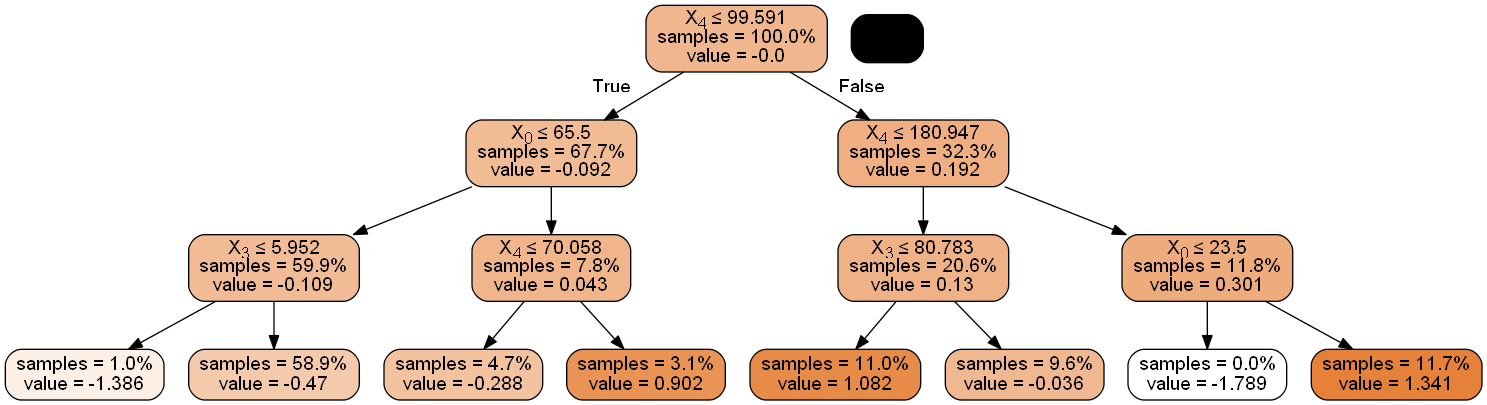

In [37]:
from sklearn.tree import export_graphviz

n_tree = randint(1, 14)
print("Tree number: " + str(int(n_tree)))
tree = GradientBoost_Inc.estimators_[n_tree, 0]

from pydotplus import graph_from_dot_data
from IPython.display import Image

dot_data = export_graphviz( tree, out_file=None, filled=True, rounded=True, 
                           special_characters=True, proportion=True, impurity=False
                          )
graph = graph_from_dot_data(dot_data)
Image(graph.create_png())


## Multi-Output Classifier
Multi-output classification is a type of machine learning that predicts multiple outputs simultaneously. In multi-output classification, the model will give two or more outputs after making any prediction. 

In [38]:
X = data
X = X.drop('ID', 1)
X = X.drop('IncomeInvestment', 1)
X = X.drop('AccumulationInvestment', 1)

Y = data
Y = Y.drop('Gender', 1)
Y = Y.drop('ID', 1)
Y = Y.drop('Age', 1)
Y = Y.drop('FamilyMembers', 1)
Y = Y.drop('FinancialEducation', 1)
Y = Y.drop('RiskPropensity', 1)
Y = Y.drop('Income', 1)
Y = Y.drop('Wealth', 1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_validate, X_test, Y_validate, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=45)

In [39]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz, export_text
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier


estimator = [GradientBoostingClassifier(), RandomForestClassifier(), AdaBoostClassifier(), ExtraTreesClassifier()]
acc = 0

for i in estimator:
    model = MultiOutputClassifier(i)
    model.fit(X_train,Y_train)
    accuracy = accuracy_score(Y_test, model.predict(X_test))
    if acc < accuracy:
        best = model
        acc = accuracy
print("The best model is: " + str(best))

The best model is: MultiOutputClassifier(estimator=RandomForestClassifier())


In [40]:
best = MultiOutputClassifier(estimator=RandomForestClassifier())
best.fit(X_train, Y_train)
Y_pred = best.predict(X_validate)
print("Accuracy score for the MultiOutput Classifier:  " + str(accuracy_score(Y_validate, Y_pred)))

Accuracy score for the MultiOutput Classifier:  0.6045454545454545


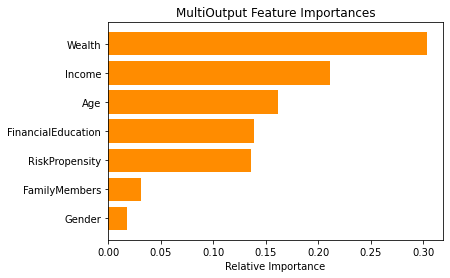

In [41]:
feat_impts = [] 
for clf in best.estimators_:
    feat_impts.append(clf.feature_importances_)

importances = np.mean(feat_impts, axis=0)
indices = np.argsort(importances)
features = X_train.columns

fig, ax = plt.subplots()

ax.set_title('MultiOutput Feature Importances')
ax.barh(range(len(indices)), importances[indices], color='darkorange', align='center')
ax.set_yticks(range(len(indices)), [features[i] for i in indices])
ax.set_xlabel('Relative Importance')
fig.show()

### Confusion Matrices for the IncomeInvestment and AccumulatioInvestment

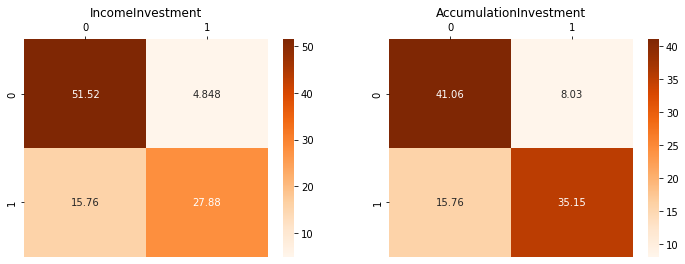

In [42]:
from sklearn.metrics import multilabel_confusion_matrix
best = MultiOutputClassifier(estimator=RandomForestClassifier())
best.fit(X_train, Y_train)
Y_pred = best.predict(X_validate)

cm = (multilabel_confusion_matrix(Y_validate, Y_pred)/len(X_validate))*100

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 4))
sns.heatmap(cm[0], annot=True, ax=ax1, fmt='.4g', cmap="Oranges")
ax1.xaxis.tick_top()
ax1.yaxis.set_ticklabels(['0','1'])
ax1.xaxis.set_ticklabels(['0','1'])
ax1.set_title('IncomeInvestment')

sns.heatmap(cm[1], annot=True, ax=ax2, fmt='.4g', cmap="Oranges")
ax2.xaxis.tick_top()
ax2.yaxis.set_ticklabels(['0','1'])
ax2.xaxis.set_ticklabels(['0','1'])
ax2.set_title('AccumulationInvestment')

fig.show()

{0: 0.7764336917562723, 1: 0.7634479717813051}


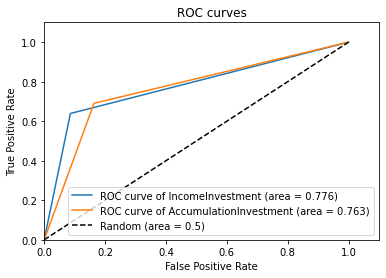

In [43]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(Y_test)

fpr[0], tpr[0], _ = roc_curve(Y_validate.IncomeInvestment, Y_pred[:,0])
roc_auc[0] = auc(fpr[0], tpr[0])

fpr[1], tpr[1], _ = roc_curve(Y_validate.AccumulationInvestment, Y_pred[:,1])
roc_auc[1] = auc(fpr[1], tpr[1])

fig, ax = plt.subplots()
ax.plot(fpr[0], tpr[0], label="ROC curve of IncomeInvestment (area = {0:0.3f})".format(roc_auc[0]))
ax.plot(fpr[1], tpr[1], label="ROC curve of AccumulationInvestment (area = {0:0.3f})".format(roc_auc[1]))
  
ax.plot([0,1], [0,1], 'k--', label='Random (area = 0.5)')
ax.set_xlim([0.0, 1.1])
ax.set_ylim([0.0, 1.1])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="lower right")
ax.set_title('ROC curves')
fig.show()

### I defined the function to find the adeguate product for a person, using a multi-output classifier, and then we apply it to our new clients

In [44]:
def double_find_product(classifier, person, products):
    y = classifier.predict([person])
    ID = -1
    product_risk = 0
    Person_risk = person.RiskPropensity
    
    if y[0][0] == y[0][1]:  # situazione in cui per entrambi i classifier la persona è nella classe 0 o 1
                        
        for x in range(len(products)):
            if Person_risk > products.iloc[x].Risk and product_risk < products.iloc[x].Risk:
                product_risk = products.iloc[x].Risk
                ID = int(products.iloc[x].IDProduct)
        
    elif y[0][0] == 1:
        for x in range(len(products)):
            if Person_risk > products.iloc[x].Risk and product_risk < products.iloc[x].Risk and products.iloc[x].Type == 0:
                product_risk = products.iloc[x].Risk
                ID = int(products.iloc[x].IDProduct)
    
    else:
        for x in range(len(products)):
            if Person_risk > products.iloc[x].Risk and product_risk < products.iloc[x].Risk and products.iloc[x].Type == 1:
                product_risk = products.iloc[x].Risk
                ID = int(products.iloc[x].IDProduct)
    return ID
    

In [45]:
new = pd.read_excel(directory +'/Needs.xls', sheet_name='New_Clients')
new_clients = new.drop('ID', 1)
ID = [None] * len(new_clients)
for i in range(len(new_clients)):
    person = new_clients.iloc[i]
    ID[i] = double_find_product(best, person, products)
    if ID[i] == -1:
        print("For the " + str(int(new.iloc[i].ID)) + " new client we don't have an adeguate product\n")
    else:
        print("For the " + str(int(new.iloc[i].ID)) + " new client the best product is: " + str(ID[i]) + "\n")

For the 1 new client the best product is: 9

For the 2 new client the best product is: 1

For the 3 new client we don't have an adeguate product

For the 4 new client the best product is: 2

For the 5 new client the best product is: 9

For the 6 new client the best product is: 2

For the 7 new client the best product is: 4

For the 8 new client the best product is: 2

For the 9 new client the best product is: 9

For the 10 new client the best product is: 1

For the 11 new client the best product is: 10

For the 12 new client the best product is: 2

For the 13 new client the best product is: 10

For the 14 new client the best product is: 2

For the 15 new client we don't have an adeguate product

For the 16 new client the best product is: 4

For the 17 new client the best product is: 2

For the 18 new client the best product is: 2

For the 19 new client the best product is: 2

For the 20 new client the best product is: 2



# XGBoost
XGBoost, which stands for Extreme Gradient Boosting, is a scalable, distributed gradient-boosted decision tree (GBDT) machine learning algorithm. 
### IncomeInvestment

In [46]:
import xgboost as xgb

X = data
X = X.drop('ID', 1)
X = X.drop('IncomeInvestment', 1)
X = X.drop('AccumulationInvestment', 1)

Y = data
Y = Y.drop('Gender', 1)
Y = Y.drop('ID', 1)
Y = Y.drop('Age', 1)
Y = Y.drop('FamilyMembers', 1)
Y = Y.drop('FinancialEducation', 1)
Y = Y.drop('RiskPropensity', 1)
Y = Y.drop('Income', 1)
Y = Y.drop('Wealth', 1)
Y = Y.drop('AccumulationInvestment', 1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=12)
Y_test_Inc = Y_test
X_validate, X_test, Y_validate, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=45)
Y_validate_Inc = Y_validate

In [47]:
model = xgb.XGBClassifier(n_estimators=10, max_depth=4, booster='gbtree',
                          reg_alpha=1, reg_lambda=2, verbosity=0)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print(accuracy)

0.7666666666666667


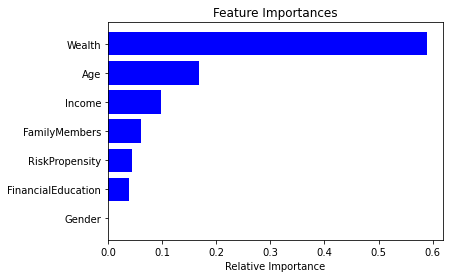

In [48]:
importances = model.feature_importances_
indices = np.argsort(importances)
features = X_train.columns

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [49]:
X = data
X = X.drop('ID', 1)
X = X.drop('IncomeInvestment', 1)
X = X.drop('AccumulationInvestment', 1)
X = X.drop('Gender', 1)

Y = data
Y = Y.drop('Gender', 1)
Y = Y.drop('ID', 1)
Y = Y.drop('Age', 1)
Y = Y.drop('FamilyMembers', 1)
Y = Y.drop('FinancialEducation', 1)
Y = Y.drop('RiskPropensity', 1)
Y = Y.drop('Income', 1)
Y = Y.drop('Wealth', 1)
Y = Y.drop('AccumulationInvestment', 1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=12)
X_test_Inc = X_test
Y_test_Inc = Y_test
X_validate, X_test, Y_validate, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=45)
Y_validate_Inc = Y_validate
X_validate_Inc = X_validate

In [50]:
estimators = [5, 10, 20, 50, 100]
max_d = [3, 4, 5, 6, 7]
booster = ['gbtree', 'gblinear', 'dart']
reg_alpha = [0, 0.5, 1, 1.5, 2]
reg_lambda = [1, 0.5, 0, 1.5, 2]
acc = 0
for i in estimators:
    for j in max_d:
        for k in booster:
            for ii in reg_alpha:
                for jj in reg_lambda:
                    
                    model = xgb.XGBClassifier(max_depth=j, n_estimators=i,
                                             booster=k, reg_alpha=ii, reg_lambda=jj,
                                             verbosity=0)
                    model.fit(X_train, Y_train)
                    Y_pred = model.predict(X_test)
                    accuracy = accuracy_score(Y_test, Y_pred)
                    
                    if accuracy > acc:
                        best = [i, j, k, ii, jj]
                        acc = accuracy

In [51]:
print(best)

[5, 6, 'gbtree', 0.5, 1.5]


#### The best parameters for the IncomeInvestment are n_estimators = 5, max_depth = 6, booster = 'gbtree', reg_alpha = 0.5, reg_lambda = 1.5

In [52]:
XGB_Inc = xgb.XGBClassifier(n_estimators=5, max_depth=6, booster='gbtree',
                            reg_alpha=0.5, reg_lambda=1.5, verbosity=0)
XGB_Inc.fit(X_train, Y_train)
Y_pred = XGB_Inc.predict(X_validate)
accuracy = accuracy_score(Y_validate, Y_pred)
print("Accuracy of XGB_Inc: " + str(accuracy))

Accuracy of XGB_Inc: 0.8106060606060606


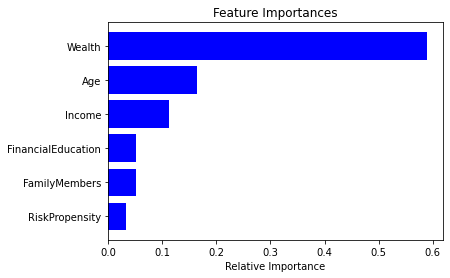

In [53]:
importances = XGB_Inc.feature_importances_
indices = np.argsort(importances)
features = X_train.columns

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## ROC and Precision-Recall curves XGBoost IncomeInvestment

AUC AccumulationInvestment case: 0.7937280689376194


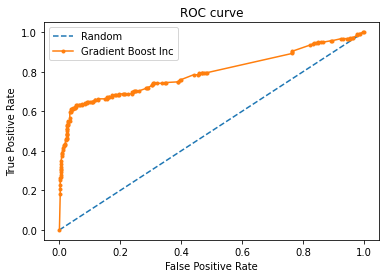

In [54]:
prob = XGB_Inc.predict_proba(X_validate)
prob = prob[:,1]

Acc_auc = roc_auc_score(Y_validate, prob)
print('AUC AccumulationInvestment case: ' + str(Acc_auc))

Acc_fpr, Acc_tpr, _ = roc_curve(Y_validate, prob)

plt.plot([0,1], [0,1], linestyle='--', label='Random')
plt.plot(Acc_fpr, Acc_tpr, marker='.', label='Gradient Boost Inc')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC curve')
plt.show()

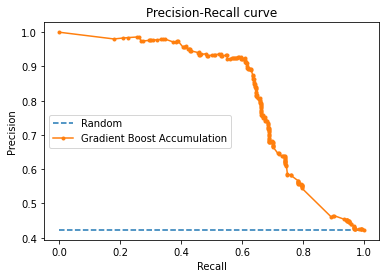

In [55]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

Y_pred = XGB_Inc.predict(X_validate)
Inc_precision, Inc_recall, _ = precision_recall_curve(Y_validate, prob)
Inc_f1, Inc_auc = f1_score(Y_validate, Y_pred), auc(Inc_recall, Inc_precision)

no_skill = len(Y_validate[Y_validate.IncomeInvestment==1])/len(Y_validate)

plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Random')
plt.plot(Inc_recall, Inc_precision, marker='.', label='Gradient Boost Accumulation')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall curve')
plt.show()


### AccumulationInvestment

In [56]:
X = data
X = X.drop('ID', 1)
X = X.drop('IncomeInvestment', 1)
X = X.drop('AccumulationInvestment', 1)
#X = X.drop('Gender', 1)

Y = data
Y = Y.drop('Gender', 1)
Y = Y.drop('ID', 1)
Y = Y.drop('Age', 1)
Y = Y.drop('FamilyMembers', 1)
Y = Y.drop('FinancialEducation', 1)
Y = Y.drop('RiskPropensity', 1)
Y = Y.drop('Income', 1)
Y = Y.drop('Wealth', 1)
Y = Y.drop('IncomeInvestment', 1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=12)
X_test_Acc = X_test
Y_test_Acc = Y_test
X_validate, X_test, Y_validate, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=45)
X_validate_Acc = X_validate
Y_validate_Acc = Y_validate

In [57]:
model = xgb.XGBClassifier(verbosity=0)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print(accuracy)

0.7848484848484848


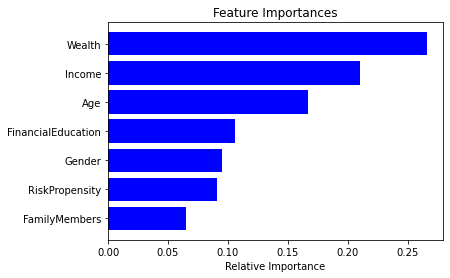

In [58]:
importances = model.feature_importances_
indices = np.argsort(importances)
features = X_train.columns

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [59]:
estimators = [5, 10, 20, 50, 100]
max_d = [3, 4, 5, 6, 7]
booster = ['gbtree', 'gblinear', 'dart']
reg_alpha = [0, 0.5, 1, 1.5, 2]
reg_lambda = [1, 0.5, 0, 1.5, 2]
acc = 0
for i in estimators:
    for j in max_d:
        for k in booster:
            for ii in reg_alpha:
                for jj in reg_lambda:
                    
                    model = xgb.XGBClassifier(max_depth=j, n_estimators=i,
                                             booster=k, reg_alpha=ii, reg_lambda=jj,
                                             verbosity=0)
                    model.fit(X_train, Y_train)
                    Y_pred = model.predict(X_test)
                    accuracy = accuracy_score(Y_test, Y_pred)
                    
                    if accuracy > acc:
                        best = [i, j, k, ii, jj, accuracy]
                        acc = accuracy

In [60]:
print(best)

[20, 7, 'gbtree', 0.5, 0, 0.8090909090909091]


#### The best parameters in the AccumulationInvestment case is n_estimators= 10, max_depth= 7, booster= 'gbtree', reg_alpha=2, reg_lambda=1

In [61]:
XGB_Acc = xgb.XGBClassifier(n_estimators=10, max_depth=7, booster='gbtree',
                            reg_alpha=2, reg_lambda=1, verbosity=0)
XGB_Acc.fit(X_train, Y_train)
Y_pred = XGB_Acc.predict(X_validate)
accuracy = accuracy_score(Y_validate, Y_pred)
print("Accuracy of XGB_Acc: " + str(accuracy))

Accuracy of XGB_Acc: 0.8242424242424242


## ROC and Precision-Recall curves XGBoost AccumulatioInvestment

AUC AccumulationInvestment case: 0.8169719819122753


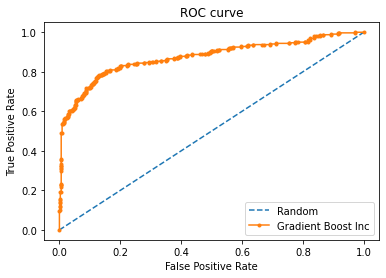

In [62]:
prob = XGB_Acc.predict_proba(X_validate)
prob = prob[:,1]

Acc_auc = roc_auc_score(Y_validate, prob)
print('AUC AccumulationInvestment case: ' + str(Inc_auc))

Acc_fpr, Acc_tpr, _ = roc_curve(Y_validate, prob)

plt.plot([0,1], [0,1], linestyle='--', label='Random')
plt.plot(Acc_fpr, Acc_tpr, marker='.', label='Gradient Boost Inc')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC curve')
plt.show()

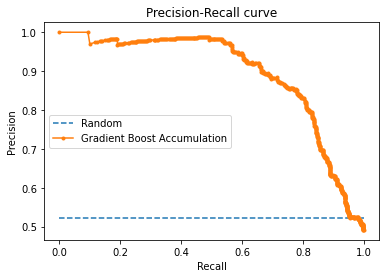

In [63]:
Y_pred = XGB_Acc.predict(X_validate)
Inc_precision, Inc_recall, _ = precision_recall_curve(Y_validate, prob)
Inc_f1, Inc_auc = f1_score(Y_validate, Y_pred), auc(Inc_recall, Inc_precision)

no_skill = len(Y_test[Y_test.AccumulationInvestment==1])/len(Y_test)

plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Random')
plt.plot(Inc_recall, Inc_precision, marker='.', label='Gradient Boost Accumulation')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall curve')
plt.show()


## Confusion matrix for both XGBoost

Text(0.5, 1.0, 'XGB_Acc')

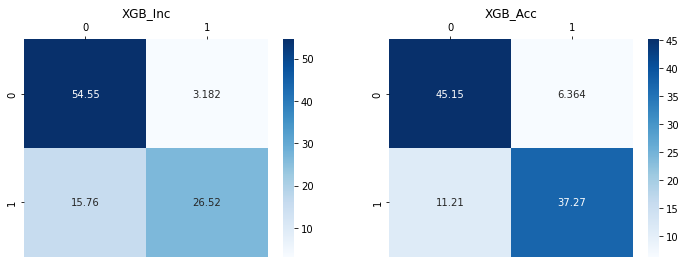

In [65]:
figsize=(6, 4)
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred_Inc = XGB_Inc.predict(X_validate_Inc)
cm_Inc = (confusion_matrix(Y_validate_Inc, Y_pred_Inc)/len(X_validate))*100

Y_pred_Acc = XGB_Acc.predict(X_validate_Acc)
cm_Acc = (confusion_matrix(Y_validate_Acc, Y_pred_Acc)/len(X_validate))*100

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 4))
sns.heatmap(cm_Inc, annot=True, ax=ax1, fmt='.4g', cmap="Blues")
ax1.xaxis.tick_top()
ax1.yaxis.set_ticklabels(['0','1'])
ax1.xaxis.set_ticklabels(['0','1'])
ax1.set_title('XGB_Inc')

sns.heatmap(cm_Acc, annot=True, ax=ax2, fmt='.4g', cmap="Blues")
ax2.xaxis.tick_top()
ax2.yaxis.set_ticklabels(['0','1'])
ax2.xaxis.set_ticklabels(['0','1'])
ax2.set_title('XGB_Acc')

